In [17]:
import discord
import os
from dotenv import load_dotenv

from api_keys import *
from command_handling import *

from DESTINY import basics
from DESTINY import manifestation
from DESTINY import hbfunc

from selenium import webdriver

import bs4
import urllib

import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

import json
import requests
import shutil

In [2]:
all_data = manifestation.get_all_data(regen=False)

Not regenerating manifest


In [3]:
weapon_dict = manifestation.get_weapon_dict(all_data)

In [4]:
perk_dict = manifestation.get_perk_dict(all_data)

In [5]:
for ep in all_data.keys():
    print(ep)

DestinyPlaceDefinition
DestinyActivityDefinition
DestinyActivityTypeDefinition
DestinyClassDefinition
DestinyGenderDefinition
DestinyInventoryBucketDefinition
DestinyRaceDefinition
DestinyTalentGridDefinition
DestinyUnlockDefinition
DestinyMaterialRequirementSetDefinition
DestinySandboxPerkDefinition
DestinyStatGroupDefinition
DestinyFactionDefinition
DestinyVendorGroupDefinition
DestinyRewardSourceDefinition
DestinyItemCategoryDefinition
DestinyDamageTypeDefinition
DestinyActivityModeDefinition
DestinyMedalTierDefinition
DestinyAchievementDefinition
DestinyActivityGraphDefinition
DestinyBondDefinition
DestinyCollectibleDefinition
DestinyDestinationDefinition
DestinyEquipmentSlotDefinition
DestinyStatDefinition
DestinyInventoryItemDefinition
DestinyItemTierTypeDefinition
DestinyLocationDefinition
DestinyLoreDefinition
DestinyMetricDefinition
DestinyObjectiveDefinition
DestinyPlugSetDefinition
DestinyPowerCapDefinition
DestinyPresentationNodeDefinition
DestinyProgressionDefinition
Desti

In [6]:
def find_id(search_id):
    for key in all_data.keys():
        if search_id in all_data[key].keys():
            print(key, "\n", json.dumps(all_data[key][search_id], indent=4))

# Command for getting random roll of random weapon
# $engram

In [7]:
print(json.dumps(weapon_dict['Annual Skate'], indent=4))

[
    {
        "displayProperties": {
            "description": "",
            "name": "Annual Skate",
            "icon": "/common/destiny2_content/icons/f288cca4a874307fff1e57bc2a295f38.jpg",
            "hasIcon": true
        },
        "tooltipNotifications": [],
        "collectibleHash": 579156770,
        "iconWatermark": "/common/destiny2_content/icons/4368a3e344977c5551407845ede830c2.png",
        "secondaryIcon": "/common/destiny2_content/icons/e9fcd73e969a9295c3ab4ee5743893c2.png",
        "backgroundColor": {
            "colorHash": 0,
            "red": 0,
            "green": 0,
            "blue": 0,
            "alpha": 0
        },
        "screenshot": "/common/destiny2_content/screenshots/6857689.jpg",
        "itemTypeDisplayName": "Hand Cannon",
        "flavorText": "\"When the lake used to freeze, people would dance on the ice wearing boots with tiny swords. And fall in love.\"",
        "uiItemDisplayStyle": "",
        "itemTypeAndTierDisplayName": "Legend

In [8]:
weapon_dict["Fatebringer"][0]['quality']['versions'][0]

{'powerCapHash': 2759499571}

In [9]:
def rollable(weapon):
    """
    Return true if weapon is legendary and is not sunset
    """
    if (weapon_dict[weapon][0]['inventory']['tierType'] == 5) & \
       (all_data['DestinyPowerCapDefinition'][weapon_dict[weapon][0]['quality']['versions'][0]['powerCapHash']]['powerCap'] == 999990):
        
        return True
    
    return False
        
    

assert(rollable("Midnight Coup") == False)
assert(rollable("Fatebringer") == True)
assert(rollable("Blast Furnace") == False)
assert(rollable("Annual Skate") == True)
assert(rollable("The Old Fashioned") == False)

Sojourner's Tale : Shotgun
| Smallbore | Steady Rounds | Rapid Hit | Opening Shot | 
Masterwork: Stability


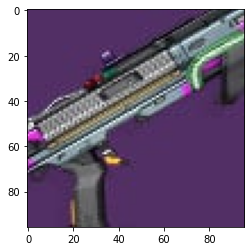

In [36]:
# TODO.  I'm not sure how to find possible masterworks, it's encoded pretty weirdly.
def masterworks(weapon):
    """
    Return possible masterworks for a weapon.
    """
    
    # ok I give up, I'm hardcoding the masterworks dict
    """
    Guide:
    0 -- normal (basically anything that shoots bullets)
    1 -- fusions (normal + charge time)
    2 -- bows (normal - range + accuracy + draw time)
    3 -- explosives (normal - range + velocity + blast radius)
    4 -- sword (impact only)
    """

    mw_dict = {
               0:["Range", "Stability", "Handling", "Reload Speed"],
               1:["Range", "Stability", "Handling", "Reload Speed", "Charge Time"],
               2:["Stability", "Handling", "Reload Speed", "Draw Time", "Accuracy"],
               3:["Stability", "Handling", "Reload Speed", "Velocity", "Blast Radius"],
               4:["Impact"]
              }
    
    arch = weapon_dict[weapon][0]['itemTypeDisplayName']
    
    
    # tree time baby
    if "Fusion" in arch:
        arch_hash = 1
    
    elif "Bow" in arch:
        arch_hash = 2
        
    elif "Launcher" in arch:
        arch_hash = 3
        
    elif "Sword" in arch:
        arch_hash = 4
    
    else:
        arch_hash = 0
        
    return mw_dict[arch_hash]


def get_icon(path):
    """
    Go to weapon icon url and download it into images/icon.png
    """
    
    path = "https://www.bungie.net" + path
    r = requests.get(path)
    with open("images/icon.png", 'wb') as f:
        f.write(r.content)


# in production this will need the usual params
def engram():
    """
    Random roll, random legendary (non-sunset)
    """
    legendary_dict = {k:v for k,v in weapon_dict.items() if rollable(k)}
    
    # perks command is bugged, some weapons return empty.  This just re-rolls until you get a good one.
    # temporary fix
    
    perks = {}
    while (len(perks.keys()) == 0):   
    
        rand = np.random.randint(len(legendary_dict))
        randweap = list(legendary_dict.keys())[rand]
        perks = hbfunc.rolls(None, randweap.split(" "), None, all_data, weapon_dict, retstr=False)

    response = randweap
    arch = weapon_dict[randweap][0]['itemTypeDisplayName']
    response += " : " + arch + "\n| "
    
    
    for key in perks.keys():
        rand = np.random.randint(len(perks[key]))
        response += perks[key][rand] + " | "
        
        
    # get masterwork
    mw_list = masterworks(randweap)
    rand = np.random.randint(len(mw_list))
    rand_mw = mw_list[rand]
    
    response += "\nMasterwork: " + rand_mw
    
    # get PNG of weapon
    get_icon(weapon_dict[randweap][0]['displayProperties']['icon'])
    
    return response
    
print(engram())
img = cv2.imread("images/icon.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# NOTE: bug in perks()
See below.

Seems like some weapons store their sockets weirdly.  The one's ive noticed are Timelost weapons, Subzero Salvo, and some others.

In [11]:
pdt = "Subzero Salvo" #"Praedyth's Revenge (Timelost)"
# the bug is here in the rolls() function: some weapons just don't return true here when they should
for socket in weapon_dict[pdt][0]['sockets']['socketEntries']:
    print("randomizedPlugSetHash" in socket.keys())

False
False
False
False
False
False
False
False
False
False


In [12]:
weapon_dict["Fatebringer"]

[{'displayProperties': {'description': '',
   'name': 'Fatebringer',
   'icon': '/common/destiny2_content/icons/a2499e40b1c62fe604359fd3bca921d2.jpg',
   'hasIcon': True},
  'tooltipNotifications': [],
  'collectibleHash': 634586904,
  'iconWatermark': '/common/destiny2_content/icons/b07d89064a1fc9a8e061f59b7c747fa5.png',
  'iconWatermarkShelved': '/common/destiny2_content/icons/a9faab035e2f59f802e99641a3aaab9e.png',
  'backgroundColor': {'colorHash': 0,
   'red': 0,
   'green': 0,
   'blue': 0,
   'alpha': 0},
  'screenshot': '/common/destiny2_content/screenshots/2171478765.jpg',
  'itemTypeDisplayName': 'Hand Cannon',
  'flavorText': 'Delivering the inevitable, one pull at a time.',
  'uiItemDisplayStyle': '',
  'itemTypeAndTierDisplayName': 'Legendary Hand Cannon',
  'displaySource': 'Random Perks: This item cannot be reacquired from Collections.',
  'action': {'verbName': 'Dismantle',
   'verbDescription': '',
   'isPositive': False,
   'requiredCooldownSeconds': 0,
   'requiredIte

In [28]:
weapon_name = "Gjallarhorn"
url = "https://www.bungie.net" + weapon_dict[weapon_name][0]['displayProperties']['icon']
r = requests.get(url)
with open("images/icon.png", 'wb') as f:
    f.write(r.content)

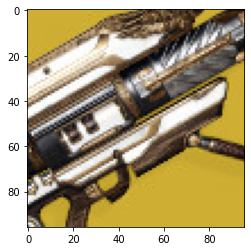

In [30]:
img = cv2.imread("images/icon.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# try sheeeeesh meme command using regex

In [1]:
message = "sheeeesh"

In [27]:
def is_sheesh(msg_ref):
    """
    Check if message contains a "sheesh" anywhere in it (regardless of capitalization or number of e's)
    
    Return True if sheesh is found, False otherwise
    """
    
    # I think let's just figure out a loop
    
    in_sheesh = False
    msg = msg_ref.lower()
    
    i = -1
    while(i < len(msg) - 1):
        i += 1
        
        if in_sheesh is False:
            if msg[i:i+4] == "shee":
                in_sheesh = True
                i += 3
                
        else:   
            if msg[i:i+2] == "sh":
                return True
            
            elif msg[i] == 'e':
                in_sheesh = True #continue
            
            else:
                in_sheesh = False
                
    return False
    

In [49]:
assert(is_sheesh("sheesh"))
assert(is_sheesh("oh SHEEEEESh"))
assert(~is_sheesh("shesh"))
assert(is_sheesh("sheesh"))
assert(~is_sheesh("shee brosh"))
assert(is_sheesh("damn bro that do be kinda fire SHEEEEEESH  though"))

In [29]:
"sheeeeesh"[0:4]

'shee'

In [30]:
is_sheesh("sheEEesh")

True

In [31]:
x = 0
while x < 20:
    print(x)
    x += 4

0
4
8
12
16


-1